In [1]:
#できることがすくない
#popularityとregionがきくのでクロス集計とってもいいかも

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold,TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from dateutil.relativedelta import relativedelta

import random
from collections import Counter,defaultdict

from copy import deepcopy
sns.set_theme(style="ticks")
# データを保存しているフォルダのディレクトリ指定
DATA_DIR = './data/'
OUTPUT_DIR = "output"

# データ読み込み

submission = pd.read_csv(os.path.join(DATA_DIR, 'sample_submit.csv'), header = None)

status_df = pd.read_csv(os.path.join(DATA_DIR, 'status.csv'))
tmp = status_df['year'].astype(str).str.cat(status_df['month'].astype(str), sep='/')
tmp = tmp.str.cat(status_df['day'].astype(str), sep='/')
#tmp = tmp.str.cat(status_df['hour'].astype(str), sep='/')
#status_df["date"] = pd.to_datetime(tmp,format='%Y/%m/%d/%H')
status_df["date"] = pd.to_datetime(tmp,format='%Y/%m/%d')


trip_df = pd.read_csv(os.path.join(DATA_DIR, 'trip.csv'))

weather_df = pd.read_csv(os.path.join(DATA_DIR, 'weather.csv'))
weather_df['date'] = pd.to_datetime(weather_df['date'])

station_df = pd.read_csv(os.path.join(DATA_DIR, 'station.csv'))

In [4]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

def savefig(fig, to):
    to = os.path.join(OUTPUT_DIR, to + '.png')
    print('save to {}'.format(to))
    fig.tight_layout()
    fig.savefig(to, dpi=120)

In [5]:
trip_df["start_date"] = pd.to_datetime(trip_df.start_date)
trip_df["end_date"] = pd.to_datetime(trip_df.end_date)

ind = (trip_df.start_station_id == 54) & (trip_df.subscription_type == "Subscriber")
trip_df[ind].sort_values("end_station_id").head(3)

,trip_id,duration,start_date,start_station_id,end_date,end_station_id,bike_id,subscription_type
240498,240498,20491,2014-05-28 05:04:00,54,2014-05-28 10:46:00,27,238,Subscriber
429112,429112,769,2015-05-13 13:50:00,54,2015-05-13 14:02:00,32,7,Subscriber
116779,116779,805,2014-01-22 13:52:00,54,2014-01-22 14:06:00,32,105,Subscriber


In [6]:
trip_df.sort_values("end_date")
trip_df[(trip_df["end_date"] > "2015-08-28") & (trip_df.end_station_id == 0)].head(3)

,trip_id,duration,start_date,start_station_id,end_date,end_station_id,bike_id,subscription_type
316021,316021,231,2015-08-31 18:12:00,2,2015-08-31 18:16:00,0,686,Subscriber
316035,316035,253,2015-08-31 18:05:00,3,2015-08-31 18:10:00,0,566,Subscriber
316042,316042,296,2015-08-31 18:03:00,2,2015-08-31 18:08:00,0,452,Subscriber


In [7]:
status_df[status_df["date"] == "2015-08-28"].head(3)#.predict.value_counts()

,id,year,month,day,hour,station_id,bikes_available,predict,date
17424,17424,2015,8,28,0,0,14.0,0,2015-08-28
17425,17425,2015,8,28,1,0,13.0,0,2015-08-28
17426,17426,2015,8,28,2,0,13.0,0,2015-08-28


In [8]:
class AbstractBaseBlock:
    def fit(self, input_df, y=None):
        return self.transform(input_df)

    def transform(self, input_df):
        raise NotImplementedError()

In [9]:
class CountEncodingBlock(AbstractBaseBlock):
    """CountEncodingを行なう block"""
    def __init__(self, column: str):
        self.column = column

    def fit(self, input_df, y=None):
        vc = input_df[self.column].value_counts()
        self._count = vc
        return self.transform(input_df)

    def transform(self, input_df):
        input_df[f"CE_{self.column}"] = input_df[self.column].map(self._count)
        return input_df

In [10]:
class MergeBlock(AbstractBaseBlock):
    def transform(self, input_df):
        input_df = pd.merge(input_df, station_df[['station_id', 'city']], how = 'left')
        weather_df_col =  ["date", 'max_temperature', 'mean_temperature', 'min_temperature',
       'max_dew_point', 'mean_dew_point', 'min_dew_point', 'max_humidity',
       'mean_humidity', 'min_humidity', 'max_sea_level_pressure',
       'mean_sea_level_pressure', 'min_sea_level_pressure', 'max_visibility',
       'mean_visibility', 'min_visibility', 'max_wind_Speed',
       'mean_wind_speed', 'precipitation', 'cloud_cover',
       'wind_dir_degrees']
        input_df = pd.merge(input_df, weather_df[weather_df_col], how = 'left')
        input_df = pd.merge(input_df, station_df[['station_id', 'lat', 'long', 'dock_count']], how = "left")
        #input_df = pd.merge(input_df, weather_df[['date', 'precipitation']], how = 'left')
        return input_df
    
class DateEncodingBlock(AbstractBaseBlock):
    def transform(self, input_df):
        input_df['week_num'] = input_df['date'].dt.weekday
        return input_df

In [11]:
class DeleteBlock(AbstractBaseBlock):
    def __init__(self, columns):
        self._columns = columns

    def transform(self, input_df):
        col = input_df.columns
        for c in self._columns:
            if c in col:
                input_df = input_df.drop(c, axis = 1)
        return input_df

In [12]:
class ZeroBikeBlock(AbstractBaseBlock):
    def __init__(self):
        self.t = status_df.groupby(['station_id', 'date']).first()['bikes_available'].reset_index()

        #self.t = pd.DataFrame(np.repeat(self.t.values, 24, axis=0))
        self.t.columns = ['station_id', 'date', 'bikes_available_at0']
        
    def transform(self, input_df):
        #input_df['bikes_available_at0'] = self.t['bikes_available_at0']
        input_df = pd.merge(input_df, self.t, on = ["station_id", "date"], how = 'left')
        #input_df["bikes_available_at0_log"] = np.log1p(input_df.bikes_available_at0)

        #print(self.t)

        return input_df
tmp = ZeroBikeBlock().transform(status_df)

In [13]:
class EncodeCityBlock(AbstractBaseBlock):
    def fit(self, input_df):
        self._le = LabelEncoder()
        self._le.fit(input_df.city)
        return self.transform(input_df)

    def transform(self, input_df):
        input_df["city"] = self._le.transform(input_df["city"])
        return input_df

In [14]:
class TargetEncodingBlock(AbstractBaseBlock):
    """TargetEncodingを行なう block"""
    def __init__(self, column: str, split = 10):
        self.column = column
        self.split = split

    def fit(self, input_df, y=None):
        input_df[self.column] = input_df[self.column]
        data_tmp = pd.DataFrame({self.column:input_df[self.column], "target":input_df["bikes_available"]})
        tmp = np.repeat(np.nan, len(input_df))

        #cv = StratifiedKFold(n_splits=self.split, random_state=14, shuffle=True)
        cv = GroupKFold(n_splits=5)
        #for idx_1, idx_2 in cv.split(input_df, input_df[self.column].astype(int)):
        for idx_1, idx_2 in cv.split(input_df, groups = input_df.group_id):
            target_mean = data_tmp.iloc[idx_1].groupby(self.column)["target"].mean()
            tmp[idx_2] = input_df.loc[idx_2][self.column].map(target_mean)
        input_df["TGT_"+self.column] = tmp
        
        self.target_mean = data_tmp.groupby(self.column)["target"].mean()
        return input_df

    def transform(self, input_df):
        input_df[ "TGT_" + self.column] = input_df[self.column].map(self.target_mean)
        return input_df

In [15]:
class TripEncodingBlock(AbstractBaseBlock):
    def __init__(self):
        x = trip_df.copy()
        self.start = x.start_station_id.value_counts()
        self.end = x.end_station_id.value_counts()
        
        x_cus = x[x.subscription_type == "Customer"]
        self.start_cus = x_cus.start_station_id.value_counts()
        self.end_cus = x_cus.end_station_id.value_counts()

        x_sub = x[x.subscription_type == "Subscriber"]
        self.start_sub = x_sub.start_station_id.value_counts()
        self.end_sub = x_sub.end_station_id.value_counts()
        
    def transform(self, input_df):
        input_df[ "Trip_start_station_id"] = input_df["station_id"].map(self.start)
        input_df[ "Trip_end_station_id"] = input_df["station_id"].map(self.end)
        input_df[ "Trip_cus_start_station_id"] = input_df["station_id"].map(self.start_cus)
        input_df[ "Trip_cus_end_station_id"] = input_df["station_id"].map(self.end_cus)
        input_df[ "Trip_sub_start_station_id"] = input_df["station_id"].map(self.start_sub)
        input_df[ "Trip_sub_end_station_id"] = input_df["station_id"].map(self.end_sub)
        return input_df

In [16]:
TripEncodingBlock().fit(status_df.copy())

,id,year,month,day,hour,station_id,bikes_available,predict,date,Trip_start_station_id,Trip_end_station_id,Trip_cus_start_station_id,Trip_cus_end_station_id,Trip_sub_start_station_id,Trip_sub_end_station_id
0,0,2013,9,1,0,0,11.0,0,2013-09-01,9558,9415,568,608,8990,8807
1,1,2013,9,1,1,0,11.0,0,2013-09-01,9558,9415,568,608,8990,8807
2,2,2013,9,1,2,0,11.0,0,2013-09-01,9558,9415,568,608,8990,8807
3,3,2013,9,1,3,0,11.0,0,2013-09-01,9558,9415,568,608,8990,8807
4,4,2013,9,1,4,0,11.0,0,2013-09-01,9558,9415,568,608,8990,8807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1226395,1226395,2015,8,31,19,69,8.0,0,2015-08-31,1747,1441,234,199,1513,1242
1226396,1226396,2015,8,31,20,69,8.0,0,2015-08-31,1747,1441,234,199,1513,1242
1226397,1226397,2015,8,31,21,69,8.0,0,2015-08-31,1747,1441,234,199,1513,1242
1226398,1226398,2015,8,31,22,69,8.0,0,2015-08-31,1747,1441,234,199,1513,1242


In [17]:
tmp = status_df['year'].astype(str).str.cat(status_df['month'].astype(str), sep='/')
#tmp = tmp.str.cat(status_df['day'].astype(str), sep='/')
status_df["group_id"] = tmp
status_df.group_id.value_counts()

2015/1     52080
2014/1     52080
2015/7     52080
2014/12    52080
2014/7     52080
2014/10    52080
2013/12    52080
2014/5     52080
2014/8     52080
2015/8     52080
2014/3     52080
2015/5     52080
2013/10    52080
2015/3     52080
2015/4     50400
2014/11    50400
2013/11    50400
2014/6     50400
2015/6     50400
2014/4     50400
2014/9     50400
2013/9     50400
2014/2     47040
2015/2     47040
Name: group_id, dtype: int64

In [19]:
feature_add_blocks = [
    MergeBlock(),
    DateEncodingBlock(),
    ZeroBikeBlock(),
    EncodeCityBlock(),
    TargetEncodingBlock(column = "station_id"),
    TargetEncodingBlock(column = "city"),
    TargetEncodingBlock(column = "hour"),
    TargetEncodingBlock(column = "week_num"),
    TripEncodingBlock(),
    DeleteBlock(['id', 'bikes_available','predict', 'date',"group_id"]),
]
#test_index = status_df.bikes_available.isnull()
#train = status_df[~test_index].copy()
#train = train[train.hour != 0]
test_index = status_df['date'] < '2014-09-01'
train = status_df[test_index]
#train = train.sort_values('date', ascending=True)
feat_train_df = train.copy()
 
for block in feature_add_blocks:
    with timer(prefix='fit {} '.format(block)):
        feat_train_df = block.fit(feat_train_df.copy())
feat_train_df.head()

fit <__main__.MergeBlock object at 0x7f5c79e59fd0> 0.330[s]
fit <__main__.DateEncodingBlock object at 0x7f5c79e59f60> 0.072[s]
fit <__main__.ZeroBikeBlock object at 0x7f5c79e59f28> 0.168[s]
fit <__main__.EncodeCityBlock object at 0x7f5c758ffc88> 0.091[s]
fit <__main__.TargetEncodingBlock object at 0x7f5c8e8e8b38> 0.628[s]
fit <__main__.TargetEncodingBlock object at 0x7f5c8e8e8d68> 0.571[s]
fit <__main__.TargetEncodingBlock object at 0x7f5c8e8e8ba8> 0.595[s]
fit <__main__.TargetEncodingBlock object at 0x7f5c8e8e8da0> 0.581[s]
fit <__main__.TripEncodingBlock object at 0x7f5c8e8e8c50> 0.072[s]
fit <__main__.DeleteBlock object at 0x7f5c8e8e8f98> 0.329[s]


,year,month,day,hour,station_id,city,max_temperature,mean_temperature,min_temperature,max_dew_point,...,TGT_station_id,TGT_city,TGT_hour,TGT_week_num,Trip_start_station_id,Trip_end_station_id,Trip_cus_start_station_id,Trip_cus_end_station_id,Trip_sub_start_station_id,Trip_sub_end_station_id
0,2013,9,1,0,0,0,81,70,61,62,...,13.13761,8.407862,8.762258,8.63441,9558,9415,568,608,8990,8807
1,2013,9,1,1,0,0,81,70,61,62,...,13.13761,8.407862,8.770833,8.63441,9558,9415,568,608,8990,8807
2,2013,9,1,2,0,0,81,70,61,62,...,13.13761,8.407862,8.746512,8.63441,9558,9415,568,608,8990,8807
3,2013,9,1,3,0,0,81,70,61,62,...,13.13761,8.407862,8.770591,8.63441,9558,9415,568,608,8990,8807
4,2013,9,1,4,0,0,81,70,61,62,...,13.13761,8.407862,8.771948,8.63441,9558,9415,568,608,8990,8807


In [20]:
test = status_df[~test_index]
#test = test[test.predict == 1]
feat_test_df = status_df.copy()

for block in feature_add_blocks:
    with timer(prefix='fit {} '.format(block)):
        feat_test_df = block.transform(feat_test_df)
feat_test_df

fit <__main__.MergeBlock object at 0x7f5c79e59fd0> 0.647[s]
fit <__main__.DateEncodingBlock object at 0x7f5c79e59f60> 0.090[s]
fit <__main__.ZeroBikeBlock object at 0x7f5c79e59f28> 0.223[s]
fit <__main__.EncodeCityBlock object at 0x7f5c758ffc88> 0.112[s]
fit <__main__.TargetEncodingBlock object at 0x7f5c8e8e8b38> 0.007[s]
fit <__main__.TargetEncodingBlock object at 0x7f5c8e8e8d68> 0.007[s]
fit <__main__.TargetEncodingBlock object at 0x7f5c8e8e8ba8> 0.007[s]
fit <__main__.TargetEncodingBlock object at 0x7f5c8e8e8da0> 0.007[s]
fit <__main__.TripEncodingBlock object at 0x7f5c8e8e8c50> 0.047[s]
fit <__main__.DeleteBlock object at 0x7f5c8e8e8f98> 0.624[s]


,year,month,day,hour,station_id,city,max_temperature,mean_temperature,min_temperature,max_dew_point,...,TGT_station_id,TGT_city,TGT_hour,TGT_week_num,Trip_start_station_id,Trip_end_station_id,Trip_cus_start_station_id,Trip_cus_end_station_id,Trip_sub_start_station_id,Trip_sub_end_station_id
0,2013,9,1,0,0,0,81,70,61,62,...,13.145320,8.394425,8.761259,8.626293,9558,9415,568,608,8990,8807
1,2013,9,1,1,0,0,81,70,61,62,...,13.145320,8.394425,8.768198,8.626293,9558,9415,568,608,8990,8807
2,2013,9,1,2,0,0,81,70,61,62,...,13.145320,8.394425,8.748681,8.626293,9558,9415,568,608,8990,8807
3,2013,9,1,3,0,0,81,70,61,62,...,13.145320,8.394425,8.769415,8.626293,9558,9415,568,608,8990,8807
4,2013,9,1,4,0,0,81,70,61,62,...,13.145320,8.394425,8.770470,8.626293,9558,9415,568,608,8990,8807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1226395,2015,8,31,19,69,0,82,72,61,62,...,7.407439,8.394425,8.457204,8.573190,1747,1441,234,199,1513,1242
1226396,2015,8,31,20,69,0,82,72,61,62,...,7.407439,8.394425,8.600195,8.573190,1747,1441,234,199,1513,1242
1226397,2015,8,31,21,69,0,82,72,61,62,...,7.407439,8.394425,8.675807,8.573190,1747,1441,234,199,1513,1242
1226398,2015,8,31,22,69,0,82,72,61,62,...,7.407439,8.394425,8.736898,8.573190,1747,1441,234,199,1513,1242


In [21]:
status_df = ZeroBikeBlock().fit(status_df)
same_ind = ~status_df.bikes_available.isna() & (feat_test_df["bikes_available_at0"] == status_df.bikes_available)
status_df["same_with_0"] = np.zeros(len(same_ind))
status_df.loc[same_ind, "same_with_0"] = 1
status_df.same_with_0 = status_df.same_with_0.astype(int)
status_df

,id,year,month,day,hour,station_id,bikes_available,predict,date,group_id,bikes_available_at0,same_with_0
0,0,2013,9,1,0,0,11.0,0,2013-09-01,2013/9,11.0,1
1,1,2013,9,1,1,0,11.0,0,2013-09-01,2013/9,11.0,1
2,2,2013,9,1,2,0,11.0,0,2013-09-01,2013/9,11.0,1
3,3,2013,9,1,3,0,11.0,0,2013-09-01,2013/9,11.0,1
4,4,2013,9,1,4,0,11.0,0,2013-09-01,2013/9,11.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1226395,1226395,2015,8,31,19,69,8.0,0,2015-08-31,2015/8,10.0,0
1226396,1226396,2015,8,31,20,69,8.0,0,2015-08-31,2015/8,10.0,0
1226397,1226397,2015,8,31,21,69,8.0,0,2015-08-31,2015/8,10.0,0
1226398,1226398,2015,8,31,22,69,8.0,0,2015-08-31,2015/8,10.0,0


In [22]:
status_df[~ind]

/home/dito/.pyenv/versions/3.6.7/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [ ]:
class AggEncodingBlock(AbstractBaseBlock):
    """CountEncodingを行なう block"""
    def __init__(self, columns: list, by, aggs = ["sum", "mean","std","max", "min"]):
        self._columns = columns
        self.aggs = aggs
        self.by = by

    def transform(self, input_df):
        for c in self._columns:
            tmp = pd.merge(input_df, 
                          input_df.groupby(self.by)[c].agg(self.aggs).reset_index(),
                          how = "left", on = self.by).drop(columns = self.by)
            tmp = tmp[self.aggs].add_prefix(f"AGG_{c}_by{self.by}")
            input_df = pd.concat([input_df, tmp], axis = 1)
        #out_df["DIFFmaxmin"] = out_df["max"] - out_df["min"]
        #return out_df.add_prefix(f'AGG_by{self.by}_' + self.column + "_")
        return input_df

In [29]:
cv = GroupKFold(n_splits=5)
X = train.copy()
y = train.copy()

for i, (idx_train, idx_valid) in enumerate(cv.split(X, y,groups = train.group_id)):
    x_train= X.iloc[idx_train]
    x_valid = X.iloc[idx_valid]
    print(x_train.group_id.unique())

['2013/9' '2013/10' '2013/11' '2014/1' '2014/2' '2014/3' '2014/4' '2014/5'
 '2014/6' '2014/7']
['2013/9' '2013/11' '2013/12' '2014/1' '2014/2' '2014/3' '2014/4' '2014/5'
 '2014/6' '2014/8']
['2013/9' '2013/10' '2013/12' '2014/1' '2014/2' '2014/3' '2014/4' '2014/7'
 '2014/8']
['2013/9' '2013/10' '2013/11' '2013/12' '2014/1' '2014/5' '2014/6'
 '2014/7' '2014/8']
['2013/10' '2013/11' '2013/12' '2014/2' '2014/3' '2014/4' '2014/5'
 '2014/6' '2014/7' '2014/8']


In [40]:
LGBM_DEFAULT_PARAMS = {
    #"objective": 'multiclass',
    'learning_rate': 0.1, 
    'max_depth': 7,
    "num_leaves": 128,
    "colsample_bytree": .8,
    'n_estimators': 300,
    'importance_type': 'gain' ,
    #"class_weight":"balanced",
    #"objective": "huber"
}
class TimeSeriesSplitGenerator:
    def __init__(self, n_split = 12, test_day_after = "2014-09-01", slide = False):
        self.test_day_after = pd.to_datetime(test_day_after)
        self.n_split = n_split
        self.test_month_period = 12
        self.month = relativedelta(months = 1)
        # self.month = relativedelta(months = self.test_month_period // n_split)

        self.slide = slide

    def split(self, X):
        for m in range(self.test_month_period):
            test_month = self.test_day_after + relativedelta(months=m)
            print(test_month)
            test_index = (test_month <= X.date) & (X.date < test_month + self.month)
            valid_index = (test_month - self.month <= X.date) & (X.date < test_month)
            train_index = (X.date < test_month - self.month)
            if self.slide:
                train_index = train_index &(
                    test_month - self.month - relativedelta(months =12) <= X.date
                )
            yield train_index, valid_index, test_index
            #yield X[train_index], X[valid_index], X[test_index]
            
def fit_and_create_predict(df, cv_df, target, n_test):
    slide = False
    cv = TimeSeriesSplitGenerator(slide = slide)
    oof_pred = np.zeros_like(cv_df[target], dtype=np.float) -1
    test_pred =  np.zeros_like(cv_df[target], dtype=np.float) -1 
    #cv_df[target] = cv_df[target]-df.bikes_available_at0
    params = deepcopy(LGBM_DEFAULT_PARAMS)
    verbose = 300
    models = []
    #if "bikes_available_at0" in df.columns:
    #    df = df.drop(columns = ["bikes_available_at0"])
    
    for i, (tr, va, te) in enumerate(cv.split(cv_df)):
        tr = tr & (df.hour != 0) & (~cv_df[target].isna()) & (~cv_df.bikes_available.isna())
        x_train, y_train = df[tr].copy(), cv_df.loc[tr, target].copy()
        
        # y_train = y_train - cv_df[tr].bikes_available_at0

        va = va & (df.hour != 0) & (~cv_df[target].isna()) & (~cv_df.bikes_available.isna())
        x_valid, y_valid = df[va].copy(), cv_df.loc[va, target].copy()
        
        te = te & (cv_df.predict == 1)
        x_test = df[te].copy()
        
        model = lgbm.LGBMRegressor(**params)
        with timer(prefix='fit fold={} '.format(i + 1)):
            model.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=300, 
                    #eval_metric='logloss',
                    verbose=verbose)
        models.append(model)

        pred_i = model.predict(x_valid)

        pred_i = [m.predict(x_valid) for m in models]
        pred_i = np.mean(pred_i, axis=0)
        
        # pred_i = pred_i + cv_df[va].bikes_available_at0

        oof_pred[va] = pred_i
        
        pred = [m.predict(x_test) for m in models]
        pred = np.mean(pred, axis=0)
        
        # pred = pred + cv_df[te].bikes_available_at0

        test_pred[te] = pred

        print(f'Fold {i} rmse: {np.sqrt(mean_squared_error(y_valid, pred_i)):.6f}')
        if False:
            classifier = lgbm.LGBMClassifier()
            y_train_class = cv_df.loc[tr, "same_with_0"].copy()
            y_valid_class = cv_df.loc[va, "same_with_0"].copy().values.reshape(-1)

            classifier.fit(x_train, y_train_class)
            pred_class = classifier.predict(x_valid)
            print(sum(pred_class == y_valid_class)/len(pred_class))

            valid_bikes_0 = cv_df.loc[va, "bikes_available_at0"].values
            #print(pred_i[y_valid_class])
            pred_i[y_valid_class] = valid_bikes_0[y_valid_class]
            #print(pred_i[y_valid_class])

            print(f'Fold {i} rmse: {np.sqrt(mean_squared_error(y_valid, pred_i)):.6f}')
            print(f'Fold {i} rmse: {np.sqrt(mean_squared_error(y_valid.values[y_valid_class], pred_i[y_valid_class])):.6f}')

            y_train_is_not_same_index = cv_df.loc[tr, "same_with_0"] == 0
            x_train_not_same = x_train[y_train_is_not_same_index]
            y_train_not_same = y_train[y_train_is_not_same_index]

            model = lgbm.LGBMRegressor(**params)
            with timer(prefix='fit fold={} '.format(i + 1)):
                model.fit(x_train_not_same, y_train_not_same)

            y_valid_is_not_same_index = cv_df.loc[va, "same_with_0"] == 0
            x_valid_not_same = x_valid[y_valid_is_not_same_index]
            y_valid_not_same = y_valid[y_valid_is_not_same_index]

            pred_valid_ns = model.predict(x_valid_not_same)

            pred_i[y_valid_is_not_same_index] = pred_valid_ns
            print(f'Fold {i} rmse: {np.sqrt(mean_squared_error(y_valid_not_same, pred_valid_ns)):.6f}')
            print(f'Fold {i} rmse: {np.sqrt(mean_squared_error(y_valid, pred_i)):.6f}')

            print("-------------------------------------------------")

    valid_index = oof_pred != -1
    score = np.sqrt(mean_squared_error(cv_df.loc[valid_index, target], oof_pred[valid_index]))
    print("----------------------")
    print('FINISHED \ whole score: {:.4f}'.format(score))
    print("----------------------")
    
    fig, ax = visualize_importance(models, df)
    ax.set_title('Importance: TARGET={}'.format(target))
    fig.tight_layout()
    savefig(fig, to=f'{target}_importance')
    plt.close(fig)
    return oof_pred, test_pred

def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:100]
    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .2)))
    sns.boxenplot(data=feature_importance_df, y='column', x='feature_importance', 
                  orient='h',
                  order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

In [41]:
oof_df, pred_df = pd.DataFrame(), pd.DataFrame()

#target_df = pd.concat([feat_train_df, feat_test_df]).reset_index().drop(columns = ["index"])
target_df = feat_test_df.copy()
n_test = len(feat_test_df)
oof, pred = fit_and_create_predict(target_df.copy(),
                                   cv_df = status_df.copy(),
                                   target = "bikes_available",
                                   n_test = n_test)

oof_df["oof"] = oof
pred_df["pred"] = pred#24587

2014-09-01 00:00:00
Training until validation scores don't improve for 300 rounds.
[300]	valid_0's l2: 5.57755
Did not meet early stopping. Best iteration is:
[158]	valid_0's l2: 5.55661
fit fold=1 6.550[s]
Fold 0 rmse: 2.357247
2014-10-01 00:00:00
Training until validation scores don't improve for 300 rounds.
[300]	valid_0's l2: 6.26412
Did not meet early stopping. Best iteration is:
[300]	valid_0's l2: 6.26412
fit fold=2 6.899[s]
Fold 1 rmse: 2.531214
2014-11-01 00:00:00
Training until validation scores don't improve for 300 rounds.
[300]	valid_0's l2: 7.27102
Did not meet early stopping. Best iteration is:
[113]	valid_0's l2: 7.13811
fit fold=3 7.150[s]
Fold 2 rmse: 2.678249
2014-12-01 00:00:00
Training until validation scores don't improve for 300 rounds.
[300]	valid_0's l2: 5.58172
Did not meet early stopping. Best iteration is:
[90]	valid_0's l2: 5.4848
fit fold=4 7.366[s]
Fold 3 rmse: 2.362263
2015-01-01 00:00:00
Training until validation scores don't improve for 300 rounds.
[30

In [182]:
if False:
    oof_index = oof_df.oof != -1
    oof_df.oof[oof_index] = oof_df.oof[oof_index] + target_df.bikes_available_at0[oof_index]
    
    pred_index = pred_df.pred != -1
    pred_df.pred[pred_index] = pred_df.pred[pred_index] + target_df.bikes_available_at0[pred_index]

In [30]:
pred_df[pred_df.pred != -1]
pred_df[status_df.predict == 1]

,pred
8761,14.861665
8762,14.841006
8763,14.861665
8764,14.861665
8765,14.861665
...,...
1226347,9.298609
1226348,9.437856
1226349,9.558020
1226350,9.625286


In [19]:
LGBM_DEFAULT_PARAMS = {
    #"objective": 'multiclass',
    'learning_rate': 0.1, 
    'max_depth': 6,
    "num_leaves": 32,
    "colsample_bytree": .7,
    'n_estimators': 1000,
    'importance_type': 'gain' ,
    #"class_weight":"balanced",
    #"objective": "huber"
}

def fit_lgbm(X, y, cv=None, params: dict=None, verbose=500):

    if params is None:
        params = deepcopy(LGBM_DEFAULT_PARAMS)

    if cv is None:
        cv = StratifiedKFold(n_splits=2, shuffle=True)
    models = []

    oof_pred = np.zeros_like(y, dtype=np.float)
    #for i, (idx_train, idx_valid) in enumerate(cv.split(X)):
    y1 = y//3

    #for i, (idx_train, idx_valid) in enumerate(cv.split(X, y1)):
    for i, (idx_train, idx_valid) in enumerate(cv.split(X, y,groups = train.group_id)):

        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        with timer(prefix='fit fold={} '.format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100, 
                    #eval_metric='logloss',
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} rmse: {np.sqrt(mean_squared_error(y_valid, pred_i)):.4f}')


    #score = roc_auc_score(y, oof_pred)
    time_invalid_index = oof_pred != 0
    score = np.sqrt(mean_squared_error(y[time_invalid_index], oof_pred[time_invalid_index]))
    print("----------------------")
    print('FINISHED \ whole score: {:.4f}'.format(score))
    print("----------------------")

    return oof_pred, models


def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:100]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .2)))
    sns.boxenplot(data=feature_importance_df, y='column', x='feature_importance', 
                  orient='h',
                  order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax


def create_predict(models, input_df) -> np.ndarray:
    """与えられた機械学習モデルで予測する"""
    pred = np.array([model.predict(input_df.values) for model in models])
    pred = np.mean(pred, axis=0)
    #pred = np.argmax(pred, axis = 1)
    return pred


def fit_and_predict(train_df, 
                    target_df, 
                    target_id):
    """対象の target_id の学習を行なう"""
    target_name = target_id

    print('-' * 20 + ' start {} '.format(target_name) + '-' * 20)

    y = target_df.values

    cv = GroupKFold(n_splits=10)
    #cv = StratifiedKFold(n_splits=5)
    #cv = TimeSeriesSplit(n_splits = 5)

    # モデルの学習.
    oof, models = fit_lgbm(train_df.values, y, cv=cv, verbose=500)

    # 特徴重要度の可視化
    fig, ax = visualize_importance(models, train_df)
    ax.set_title('Importance: TARGET={}'.format(target_name))
    fig.tight_layout()
    savefig(fig, to=f'{target_name}_importance')
    plt.close(fig)

    return oof, models

In [20]:
import pickle
if False:
    with open('tmp_data.pickle', 'rb') as f:
        y, feat_train_df = pickle.load(f)


In [21]:
oof_df, pred_df = pd.DataFrame(), pd.DataFrame()
_train = train.copy()
#_train.bikes_available = _train.bikes_available.values - feat_train_df.bikes_available_at0.values
oof, models = fit_and_predict(train_df=feat_train_df, 
                            target_df=_train.bikes_available,
                            target_id="bikes_available")

# 予測モデルで推論実行
with timer(prefix='predict'):
    pred = create_predict(models, input_df=feat_test_df)

oof_df["oof"] = oof
pred_df["pred"] = pred

-------------------- start bikes_available --------------------


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [286]:
valid_oof = oof != 0
np.sqrt(mean_squared_error(oof[valid_oof], train.bikes_available[valid_oof]))

2.29687494636359

In [42]:
predict_index = status_df.predict == 1
exp_pred = pred_df.pred[predict_index].values
# exp_pred = target_df.bikes_available_at0[predict_index].values

In [43]:
submission[1] = np.clip(exp_pred, 0, 27)
if False:
    f0 = feat_test_df.bikes_available_at0[predict_index[0].values]
    submission[1] += f0

submission.head(20)
submission

,0,1
0,8761,14.861665
1,8762,14.841006
2,8763,14.861665
3,8764,14.861665
4,8765,14.861665
...,...,...
193195,1226347,9.663557
193196,1226348,9.707198
193197,1226349,9.785504
193198,1226350,9.821473


In [44]:
submission.to_csv(os.path.join(OUTPUT_DIR, 'submission16.csv'), index=False, header = False)

<AxesSubplot:ylabel='Density'>

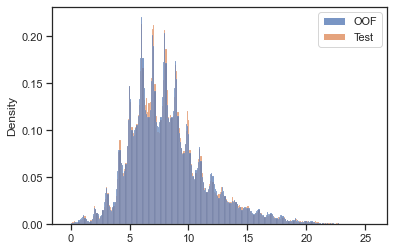

In [35]:
sns.histplot(data=pd.DataFrame({
            'OOF': oof_df[oof_df.oof != -1].oof,
            'Test': pred_df.pred[pred_df.pred != -1]}), stat='density', common_norm=False,)

<AxesSubplot:ylabel='Density'>

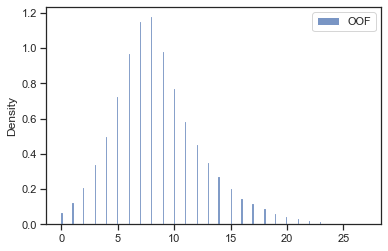

In [32]:
sns.histplot(data=pd.DataFrame({
            'OOF': status_df[~status_df.bikes_available.isna(
            )].bikes_available,
         }), stat='density', common_norm=False,)

In [45]:
# !signate submit -c 550 output/submission16.csv

You have successfully submitted your predictions.We will send you the submission result to your email address.


In [71]:
!signate list

  competitionId  title                                                              closing     prize                    submitters
---------------  -----------------------------------------------------------------  ----------  ---------------------  ------------
              1  【練習問題】銀行の顧客ターゲティング                               -                                          5196
             24  【練習問題】お弁当の需要予測                                       -                                          6371
             27  【練習問題】Jリーグの観客動員数予測                                -                                          1434
            100  【練習問題】手書き文字認識                                         -           Knowledge                       176
            102  【練習問題】タイタニックの生存予測                                 -           Knowledge                      1094
            103  【練習問題】音楽ラベリング                                         -           Knowledge                        61
            104  【練習問題】スパムメール分類     

In [308]:
x = status_df[status_df['date'] > '2014-09-01']
x = x[~x.bikes_available.isna()]
x.group_id.value_counts()

2015/8     19180
2015/5     19180
2014/12    19180
2014/10    19180
2015/7     19180
2015/1     19180
2015/3     19180
2014/11    17500
2015/4     17500
2015/6     17500
2014/9     17430
2015/2     14140
Name: group_id, dtype: int64

In [18]:
oof_df[oof_df.oof != -1].oof

8017       11.513627
8018       11.513627
8019       11.513627
8020       11.513627
8021       11.513627
             ...    
1225603     7.710523
1225604     7.877799
1225605     7.917130
1225606     8.131776
1225607     8.165666
Name: oof, Length: 233450, dtype: float64

In [165]:
status_df[(status_df.year == 2013)&(status_df.day == 29)&(status_df.station_id == 69)&(status_df.month == 9)]

,id,year,month,day,hour,station_id,bikes_available,predict,date
1209552,1209552,2013,9,29,0,69,NaN,0,2013-09-29
1209553,1209553,2013,9,29,1,69,NaN,0,2013-09-29
1209554,1209554,2013,9,29,2,69,NaN,0,2013-09-29
1209555,1209555,2013,9,29,3,69,NaN,0,2013-09-29
1209556,1209556,2013,9,29,4,69,NaN,0,2013-09-29
1209557,1209557,2013,9,29,5,69,NaN,0,2013-09-29
1209558,1209558,2013,9,29,6,69,NaN,0,2013-09-29
1209559,1209559,2013,9,29,7,69,NaN,0,2013-09-29
1209560,1209560,2013,9,29,8,69,NaN,0,2013-09-29
1209561,1209561,2013,9,29,9,69,NaN,0,2013-09-29


In [207]:
pred_df.pred[pred_df.pred != -1]

8761       12.841217
8762       12.841217
8763       12.841217
8764       12.841217
8765       12.841217
             ...    
1226347     7.287060
1226348     7.591637
1226349     7.817561
1226350     7.884233
1226351     7.911653
Name: pred, Length: 193200, dtype: float64

In [250]:
#pred_df_at0 = pred_df.copy()
#oof_df_at0 = oof_df.copy()

In [232]:
st = status_df.copy()
st["test_pred"] = pred_df.pred
st["oof_pred"] = oof_df.oof
st["test_pred_at0"] = pred_df_at0.pred
st["oof_pred_at0"] = oof_df_at0.oof
st[~save_index].to_csv("output/pred_status.csv")

In [229]:
a = st["test_pred"] == -1 
b = st["oof_pred"] == -1
c = st["test_pred_at0"] == -1
d = st["oof_pred_at0"] == -1
save_index = a & b & c & d

In [259]:
status_df.bikes_available.max()

27.0

In [279]:
a = status_df[~status_df.bikes_available.isna(
            )].bikes_available - status_df[~status_df.bikes_available.isna()].bikes_available_at0

In [281]:
a.value_counts()

 0.0     365303
-1.0      87015
 1.0      85655
-2.0      44362
 2.0      41228
-3.0      27077
 3.0      24875
-4.0      19191
 4.0      17038
-5.0      14294
 5.0      12468
-6.0      10447
 6.0       9052
-7.0       7765
 7.0       6571
-8.0       5895
 8.0       4585
-9.0       4259
 9.0       3353
-10.0      3337
-11.0      2399
 10.0      2376
-12.0      1883
 11.0      1586
-13.0      1484
-14.0      1165
 12.0      1049
-15.0       843
 13.0       728
-16.0       601
-17.0       457
 14.0       424
-18.0       266
 15.0       262
-19.0       173
 16.0       142
-20.0       100
-21.0        79
 17.0        61
 18.0        49
-22.0        35
 19.0        20
 20.0        15
-23.0        11
 21.0        11
 22.0         3
-26.0         1
-25.0         1
-24.0         1
dtype: int64